Load Packages
===============

In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets

Load Data:
===============

In [2]:
import codecs

In [3]:
download = datasets.FashionMNIST('./FMNIST/', train=True, download=True) 

In [10]:
Datapath = 'FMNIST/FashionMNIST/raw/'

In [11]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [12]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [13]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [14]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [15]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [16]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


In [17]:
use_gpu = torch.cuda.is_available()

Define the Autoencoder:
===============

In [18]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import copy


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


Define Optimization Technique:
===============

In [19]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

Train Autoencoder:
===========

In [22]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.104054
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.065966
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.053548
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.046709
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.043336
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.041098
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.039761
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.038583
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.037640
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.036554
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.035197
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.034388
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.033925
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.033375
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.032810
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.032317
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.031863
At Iteration : 18 / 30  ;  Mean-Squared 

Testing Autoencoder Performance:
=================

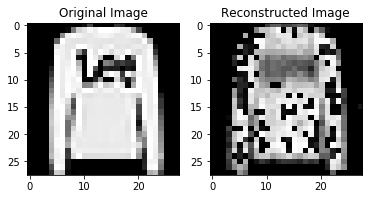

In [23]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))
if use_gpu:
    outputImg = net(Variable((TestImg.double().cuda())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28).cpu()
else:
    outputImg = net(Variable((TestImg.double())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28)

TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()



Adding more Layers:
=================

In [24]:
net.encoder.add_module('layer', nn.Sequential(nn.Linear(100, 100),nn.ReLU(),nn.Linear(100, 100),nn.ReLU()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (layer): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [26]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.114873
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.079118
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.067747
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.060690
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.055994
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.051834
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.049523
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.047974
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.046922
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.045811
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.044944
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.044067
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.043582
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.043167
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.042456
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.041257
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.040670
At Iteration : 18 / 30  ;  Mean-Squared 

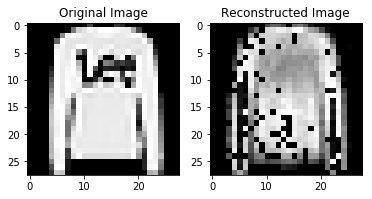

In [27]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))
if use_gpu:
    outputImg = net(Variable((TestImg.double().cuda())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28).cpu()
else:
    outputImg = net(Variable((TestImg.double())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28)

TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

Remove Decoder and Add Classification Layer: 
================================

In [28]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
new_classifier = nn.Sequential(*list(new_classifier[0].children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


Define Optimizer:
================================

In [29]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train Classifier:
===========

In [ ]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data
    inputs = TestImages.double()/255
    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.size()[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

C:\Users\asrivastava01\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Iteration: 1 / 30  ;  Training Loss: 1.676860 ; Testing Acc: 73.000000 
At Iteration: 2 / 30  ;  Training Loss: 0.666953 ; Testing Acc: 77.000000 
At Iteration: 3 / 30  ;  Training Loss: 0.609063 ; Testing Acc: 78.000000 
At Iteration: 4 / 30  ;  Training Loss: 0.574864 ; Testing Acc: 79.000000 
At Iteration: 5 / 30  ;  Training Loss: 0.549581 ; Testing Acc: 80.000000 
At Iteration: 6 / 30  ;  Training Loss: 0.529695 ; Testing Acc: 80.000000 
At Iteration: 7 / 30  ;  Training Loss: 0.513596 ; Testing Acc: 81.000000 
At Iteration: 8 / 30  ;  Training Loss: 0.500235 ; Testing Acc: 81.000000 
At Iteration: 9 / 30  ;  Training Loss: 0.488939 ; Testing Acc: 81.000000 
At Iteration: 10 / 30  ;  Training Loss: 0.479307 ; Testing Acc: 81.000000 
At Iteration: 11 / 30  ;  Training Loss: 0.470946 ; Testing Acc: 82.000000 
At Iteration: 12 / 30  ;  Training Loss: 0.463594 ; Testing Acc: 82.000000 
At Iteration: 13 / 30  ;  Training Loss: 0.457009 ; Testing Acc: 82.000000 
At Iteration: 14 / 30